In [12]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
#from keras.layers.core import MaxoutDense
from models.maxout_layers import Maxout1D

#dropout_enable = False

#model_file = "DL1_AntiKt4EMTopo_dropout" if dropout_enable else "DL1_AntiKt4EMTopo"
import models.rebuild_DL1 as DL1

#model = tf.keras.models.load_model("DL1_AntiKt4EMTopo")
#model_dropout = tf.keras.models.load_model("DL1_AntiKt4EMTopo_dropout")
#test_model.summary()

#filename.root:Tdirectory/directory/obj
File_path="BTagCalibRUN2-08-40.root:DL1/AntiKt4EMTopo/net_configuration"

DL1_struct = DL1.get_net_struct(File_path)
DL1_weights = DL1_struct['layers']

#DL1_layers = [ 72, 57, 60, 48, 36,24, 12, 6]
DL1_dropouts = [0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]

#findout input size, and weight matrix for each layer.
#create corresponding tensorflow layers and store them in a list.
features, dl1_layers, dl1_weights = DL1.pars_layers(DL1_struct['layers'])

model = DL1.get_DL1(features , dl1_layers, drops=None )
model_dropout = DL1.get_DL1(features , dl1_layers, drops=DL1_dropouts )
model.summary()
DL1.set_dl1_weights(model=model, weights=dl1_weights)
DL1.set_dl1_weights(model=model_dropout, weights=dl1_weights)

import h5py
#get test dataset
hf = h5py.File("/Users/abletimin/cernbox/b-tagg/MC16_ttbar-test-even-bjets.h5", 'r')
X_test, Y_test = hf['X_test'][:100000], hf['Y_test'][:100000]
hf.close()

def DL1_socre(pb, pc, pl): 
    return np.log(pb/(0.08*pc + 0.92*pl))

def plot_prob_score(pb, pc, pl, DL1_socre, range=(0,1)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    _n, bins, _ = ax1.hist(pb, bins=50, range=range, alpha=0.5, label="p_b")
    _ = ax1.hist(pc, bins=bins, alpha=0.5, label="p_c")
    _ = ax1.hist(pl, bins=bins, alpha=0.5, label="p_l")
    ax1.legend(loc="upper right")
    
    _ =ax2.hist(DL1_socre(pb, pc, pl), 100, alpha=0.6)
    


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 41)]              0         
_________________________________________________________________
maxout0 (Maxout1D)           (None, 72)                75600     
_________________________________________________________________
activ0 (Activation)          (None, 72)                0         
_________________________________________________________________
BN1 (Normalization)          (None, 72)                5256      
_________________________________________________________________
dense2 (Dense)               (None, 57)                4161      
_________________________________________________________________
BN3 (Normalization)          (None, 57)                3306      
_________________________________________________________________
dense4 (Dense)               (None, 60)                3480

 ## test two models 
 
1. with drop out.
2. without dropout.

In [13]:
re_dropout = model_dropout(np.array(10000*[X_test[9]]), training=False).numpy()

#no dropout
re = model(X_test, training=False).numpy()

score for jet 9:  4.3724794


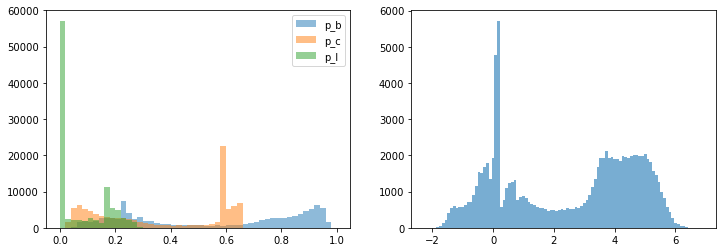

In [14]:
import matplotlib
import matplotlib.pyplot as plt

pb = re[:,2]
pc = re[:,1]
pl = re[:,0]

plot_prob_score(pb, pc, pl ,DL1_socre)

print("score for jet 9: ", DL1_socre(pb, pc, pl)[9])



mean score:  5.103032


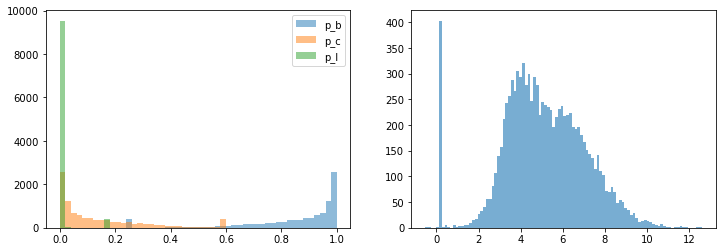

In [16]:
#with dropout enabled
pb = re_dropout[:,2]
pc = re_dropout[:,1]
pl = re_dropout[:,0]

plot_prob_score(pb, pc, pl ,DL1_socre)
print("mean score: ", DL1_socre(pb, pc, pl).mean())

In [18]:
np.sum(DL1_socre(re[:,2], re[:,1], re[:,0])>1.45)/len(re[:,0])

0.59981

## truth score VS mean score 

* Truth core is the DL1 b-tagging score calculated without dropout probablity disabled.  
* Mean score for a jet is the averarage DL1 score of 10000 evaluations with dropout probablity enabled.

### truth score

mis-tagg rage:  0.59981


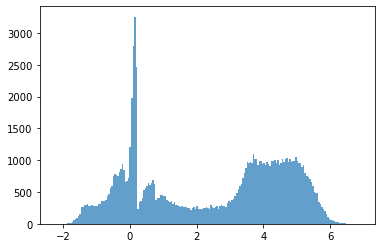

In [19]:
truth_score = DL1_socre(re[:,2], re[:,1], re[:,0])
_ =plt.hist(truth_score, bins=200, alpha=0.7)
print("mis-tagg rage: ",np.sum(truth_score>1.45)/len(re[:,0]) )

### Mean score

In [20]:
%%time
def get_mean_score(X_test, model):
    def _mean_score(inputs):
        result_prob = model(np.array(10000*[inputs]), training=False).numpy()
        result = DL1_socre(result_prob[:,2], result_prob[:,1], result_prob[:,0])
        return result.mean(), result.std()

    return np.apply_along_axis(_mean_score,1, X_test)
    
mean_score=get_mean_score(X_test[:100,:], model_dropout)


<ipython-input-12-6d50f5508efa>:44: RuntimeWarning: overflow encountered in log
  return np.log(pb/(0.08*pc + 0.92*pl))


CPU times: user 1min 48s, sys: 21.3 s, total: 2min 10s
Wall time: 2min 24s


mis-tagg rage:  0.68


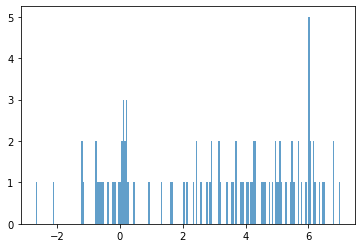

In [21]:
_ =plt.hist(mean_score[:,0], 200, alpha=0.7)
print("mis-tagg rage: ",np.sum(mean_score[:,0]>1.45)/len(mean_score[:,0]) )

In [22]:
X_test.shape[0]/100*30/(60*60) #h

8.333333333333334